# Flow-CyTOF integration & scatter imputation

In [1]:
import cytovi
import anndata as ad
import pandas as pd
import numpy as np
import os
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import readfcs

'param_use_gpu' is not a valid key!


In [2]:
os.chdir('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure3/'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)

In [3]:
# load data
adata_flow = ad.read_h5ad('../data/raw/Spectral flow/Nunez/For Chiquito/annotated/2024-01-24_norm_sample_batch1_ann.h5ad')
adata_cytof = ad.read('../data/raw/CyTOF/twins/surface/batch1/annotated/2024-05-22_norm_samples_batch1_ann_100k.h5ad')

# clean vars
rm_vars_flow = ['CXCR3', 'PD1']
adata_flow = adata_flow[:, [var for var in adata_flow.var_names if var not in rm_vars_flow]].copy()

rm_vars_cytof = ['CD138']
adata_cytof = adata_cytof[:, [var for var in adata_cytof.var_names if var not in rm_vars_cytof]].copy()
adata_cytof.var.rename(index={'TCRgd': 'TCRGD'}, inplace=True)


In [6]:
mapping_flow = {
    'B cells': 'B cells',
    'CD56dim NK cells': 'NK cells',
    'CD56high NK cells': 'NK cells',
    'Classical monocytes': 'Monocytes',
    'Cytotoxic memory T cells': 'Memory Cytotoxic T cells',
    'Dendritic cells': 'Dendritic cells',
    'KLRG1+ Th cells': 'Memory T helper cells',
    'KLRG1+ cytotoxic memory T cells': 'Memory Cytotoxic T cells',
    'Memory Th cells': 'Memory T helper cells',
    'Naive Th cells': 'Naive T helper cells',
    'Naive cytotoxic T cells': 'Naive Cytotoxic T cells',
    'Non-classical monocytes': 'Monocytes', 
    'Plasmacytoid dendritic cells': 'Plasmacytoid dendritic cells',
    'Regulatory T cells': 'Regulatory T cells', 
    'Unknown': 'Unknown',
    'gd T cells': 'gd T cells'
}

mapping_cytof = {
    'Memory B cells': 'B cells',
    'Memory CD4 T cells' : 'Memory T helper cells',
    'Memory CD8 T cells': 'Memory Cytotoxic T cells',
    'Monocytes': 'Monocytes',
    'NK cells': 'NK cells',
    'Naive B cells': 'B cells',
    'Naive CD4 T cells': 'Naive T helper cells',
    'Naive CD8 T cells': 'Naive Cytotoxic T cells',
    'Regulatory T cells': 'Regulatory T cells',
    'Unknown': 'Unknown'
}

adata_flow.obs['harmonized_labels'] = adata_flow.obs['cell_type'].map(mapping_flow).astype('category')
adata_cytof.obs['harmonized_labels'] = adata_cytof.obs['cell_type'].map(mapping_cytof).astype('category')

# train model

In [7]:
# combine datasets
adata = cytovi.pp.merge_batches([adata_flow, adata_cytof])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CCR4, CCR7, CD127, CD14, CD16, CD19, CD27, CD3, CD38, CD4, CD45RA, CD56, CD69, CD8, FOXP3, HLADR, TCRGD


In [8]:
# train model
train_kwargs = {
        'max_epochs': 50,
        'n_epochs_kl_warmup': 10}

        
cytovi.CytoVI.setup_anndata(
    adata,
    layer="scaled",
    batch_key='batch',
    labels_key='harmonized_labels'
)

model = cytovi.CytoVI(adata)
model.train(**train_kwargs)

In [9]:
# save model to disk
model.save('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-26_scatter_imputation_200k', overwrite=True)

In [10]:
# load again
model = cytovi.CytoVI.load('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-26_scatter_imputation_200k', adata = adata)

INFO     File                                                                                                      
         /home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-26_scatter_imputation_200k/mod
         el.pt already downloaded                                                                                  


Found nan_layer in adata. Will register nan_layer for missing marker imputation.


Text(0, 0.5, 'elbo_validation')

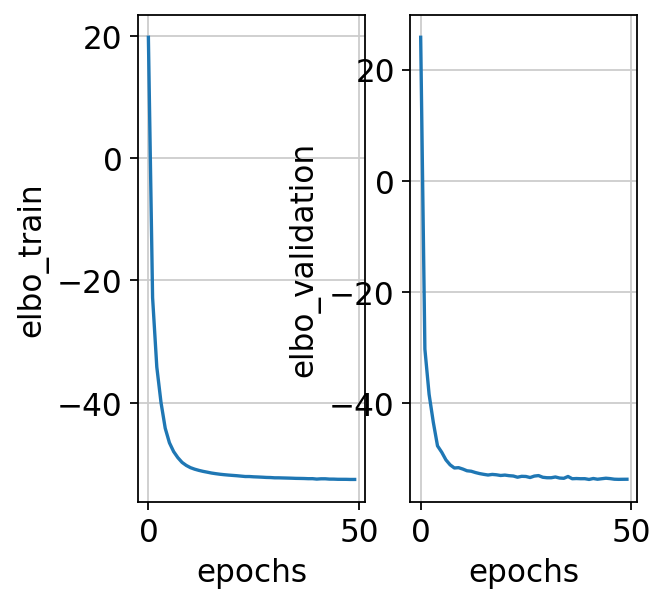

In [100]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

In [11]:
# compute umap and cluster CytoVI latent space
adata.obsm["X_CytoVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_CytoVI")
sc.tl.umap(adata)

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


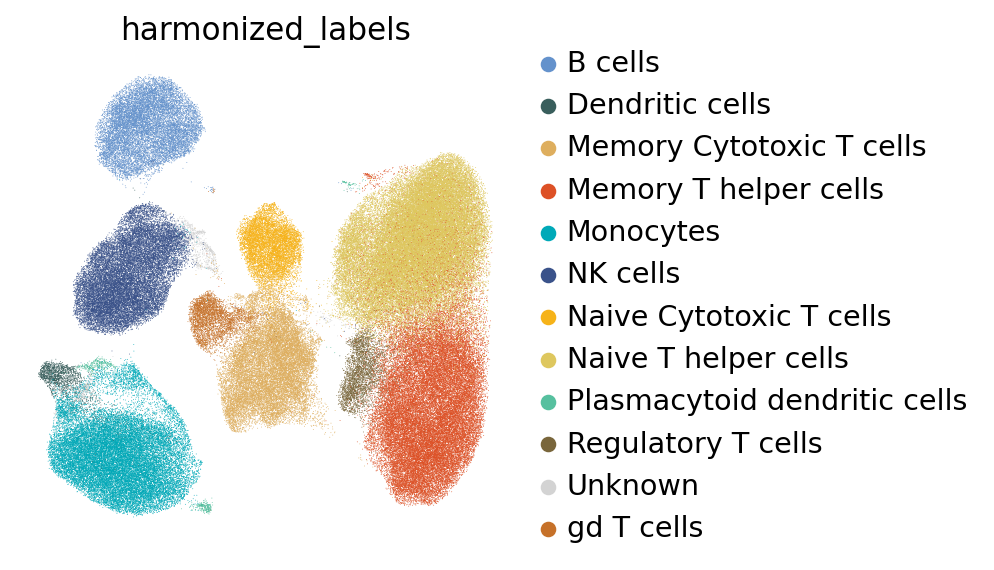

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


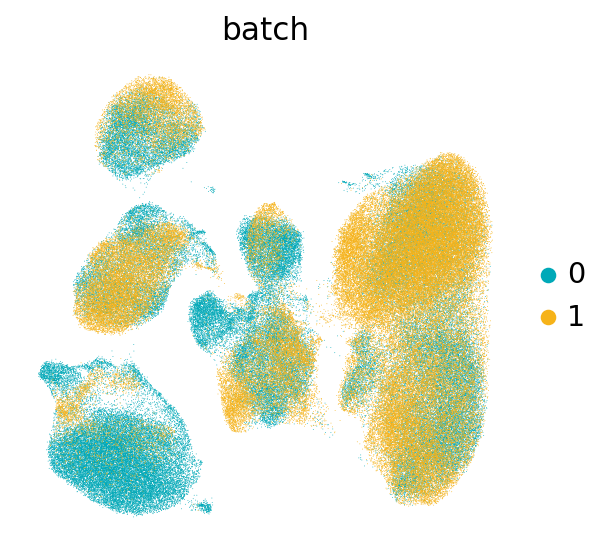

In [4]:
# plot data
cell_type_colors = {
    'B cells': '#6492CC', 
    'Dendritic cells': '#395E5C',  
    'Memory Cytotoxic T cells': '#DEAE5E',  
    'Memory T helper cells': '#DD5126',  
    'Monocytes': '#00A9B8',
    'NK cells': '#3A528A', 
    'Naive Cytotoxic T cells': '#F6B319',  
    'Naive T helper cells': '#DEC75E', 
    'Plasmacytoid dendritic cells': '#56C09F', 
    'Unknown': 'lightgrey', 
    'gd T cells': '#C67129', 
    'Regulatory T cells': '#79663B',
}


sc.pl.umap(adata, color=["harmonized_labels"], palette = cell_type_colors, frameon = False, save ='scatter_imputation_umap_cell_types.png')

batch_colors = ['#00A9B8', '#F6B319']
sc.pl.umap(adata, color = ['batch'], palette = batch_colors, frameon = False, save = 'scatter_imputation_umap_batch.png')

In [13]:
# impute missing markers
adata.layers['imputed'] = model.get_normalized_expression(adata, n_samples = 10)

detected missing proteins between batches - will impute missing markers


In [3]:
# load anndata again if needed
adata = ad.read_h5ad('../data/2024-06-14_imputation_eval_batch/2024-08-27_kreutmair_nunez_annotated_imputed.h5ad')

Group B cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Monocytes has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Naive Cytotoxic T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Regulatory T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
No contour levels were found within the data range.


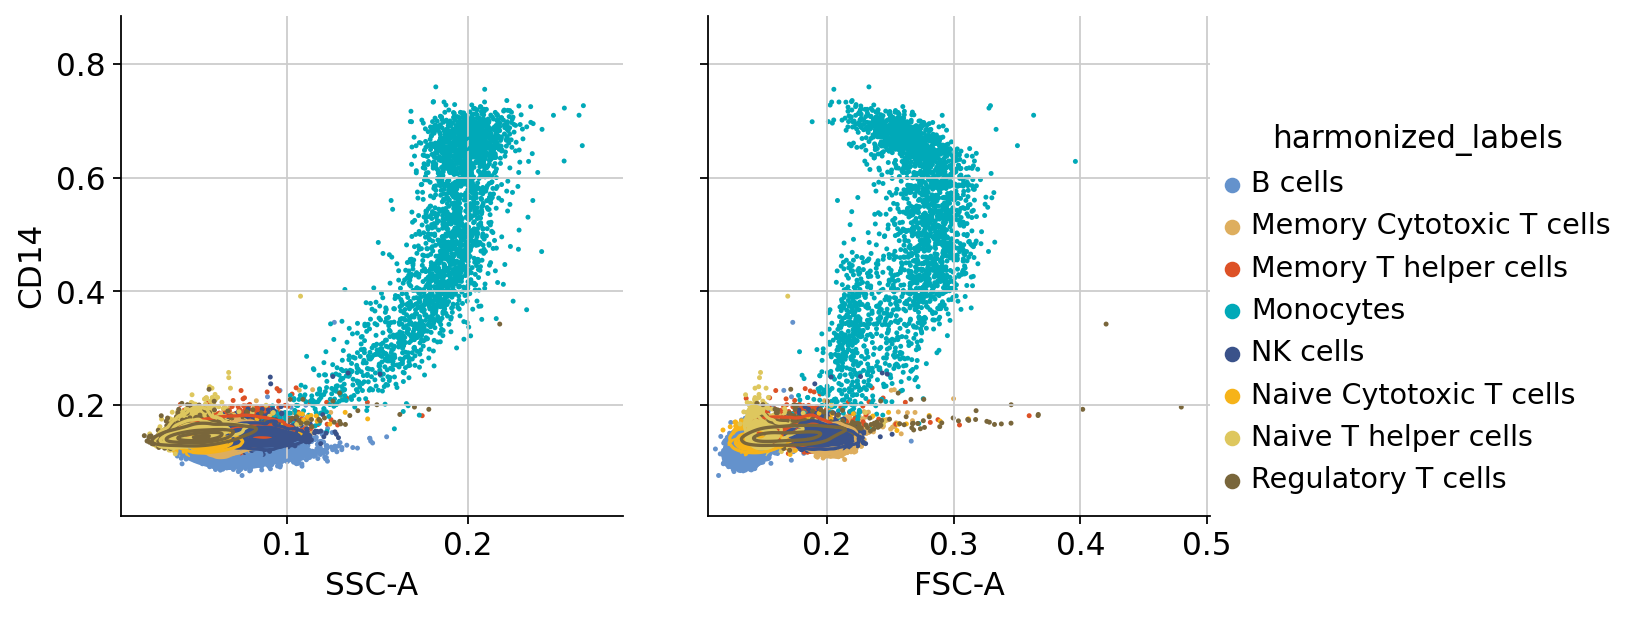

Group B cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Monocytes has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Naive Cytotoxic T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Regulatory T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
No contour levels were found within the data range.


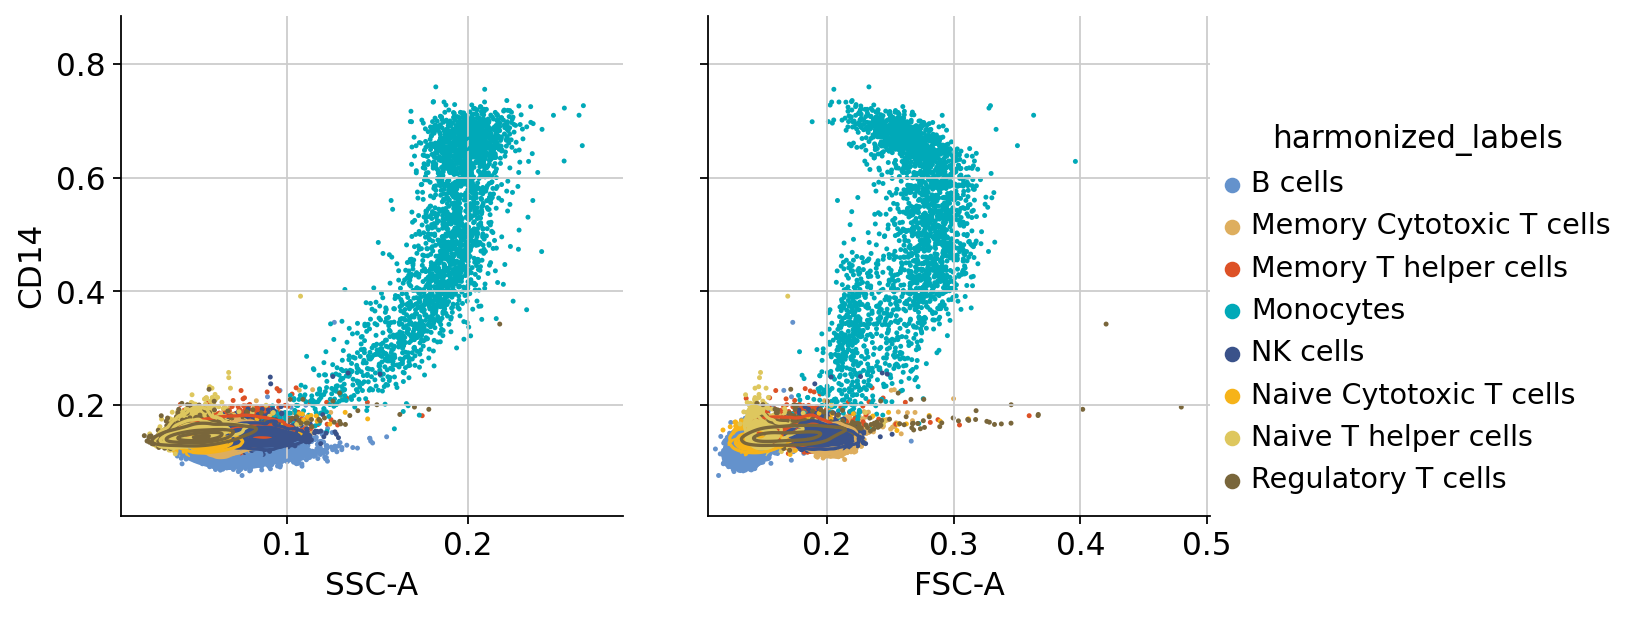

Group B cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Monocytes has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Naive Cytotoxic T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Regulatory T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.


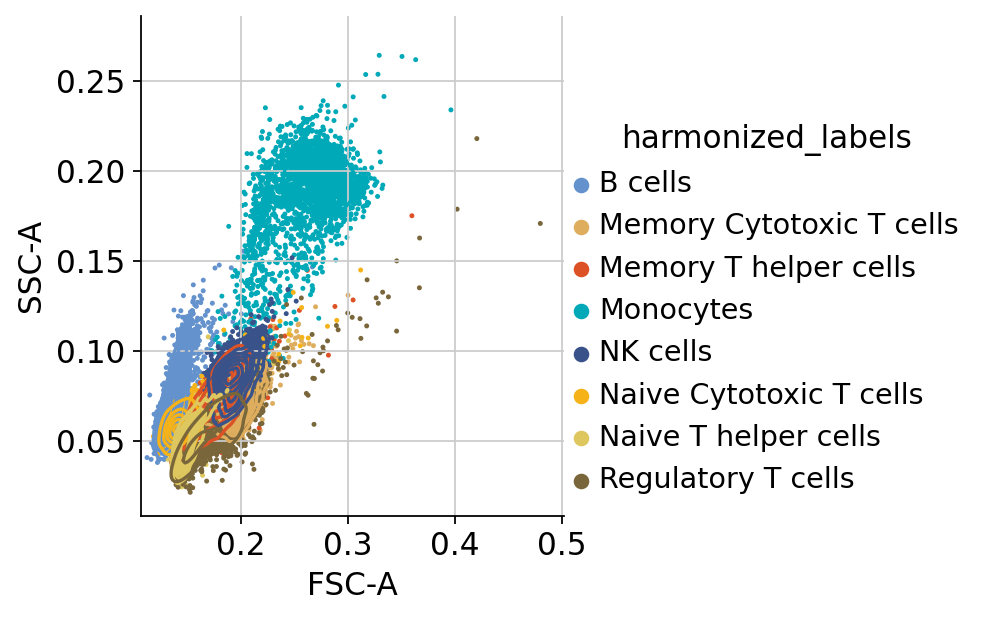

Group B cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Monocytes has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Naive Cytotoxic T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.
Group Regulatory T cells has less observations than 6250 observations.Taking all group observations. Set replace to True to sample with replacement.


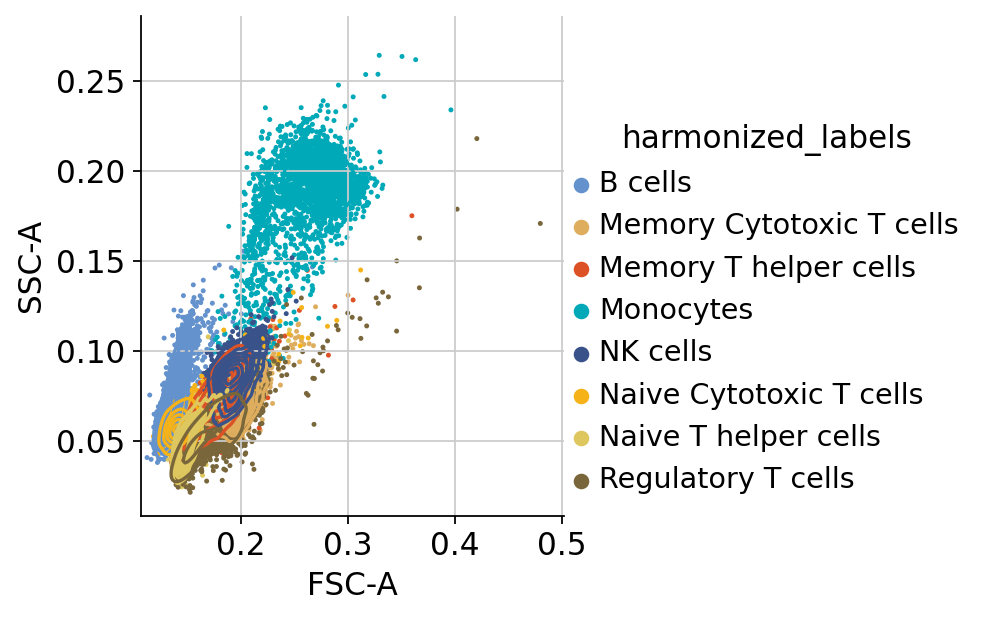

In [8]:
# plot imputed fcs
cytof_kwargs = {
    'layer_key': 'imputed',
    'color': 'harmonized_labels',
    'n_obs': 50000,
    'height': 4,
    'palette': cell_type_colors,
    'sample_color_groups': True,
    'scatter_kwargs': {'edgecolor': 'none'},
}

adata_cytof = adata[adata.obs['batch']=='1'].copy()
adata_cytof = adata_cytof[adata_cytof.obs['cell_type']!= 'Unknown']

cytovi.pl.biaxial(adata_cytof, marker_y = 'CD14', marker_x = ['FSC-A', 'SSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_CyTOF_CD14_scatter.png', **cytof_kwargs)
cytovi.pl.biaxial(adata_cytof,marker_y = 'CD14', marker_x = ['FSC-A', 'SSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_CyTOF_CD14_scatter.pdf', **cytof_kwargs)
cytovi.pl.biaxial(adata_cytof, marker_y = 'SSC-A', marker_x = ['FSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_CyTOF_scatter.png', **cytof_kwargs)
cytovi.pl.biaxial(adata_cytof, marker_y = 'SSC-A', marker_x = ['FSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_CyTOF_scatter.pdf', **cytof_kwargs)

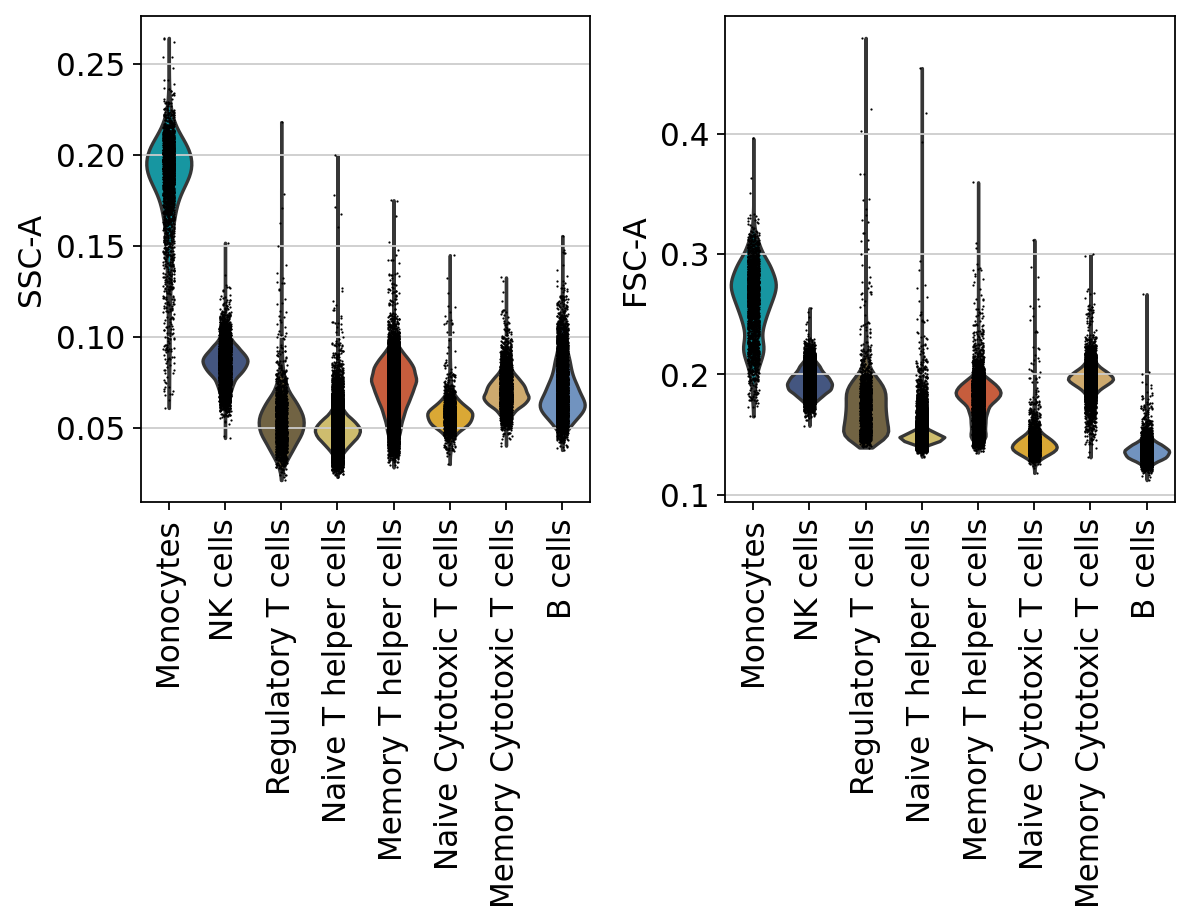

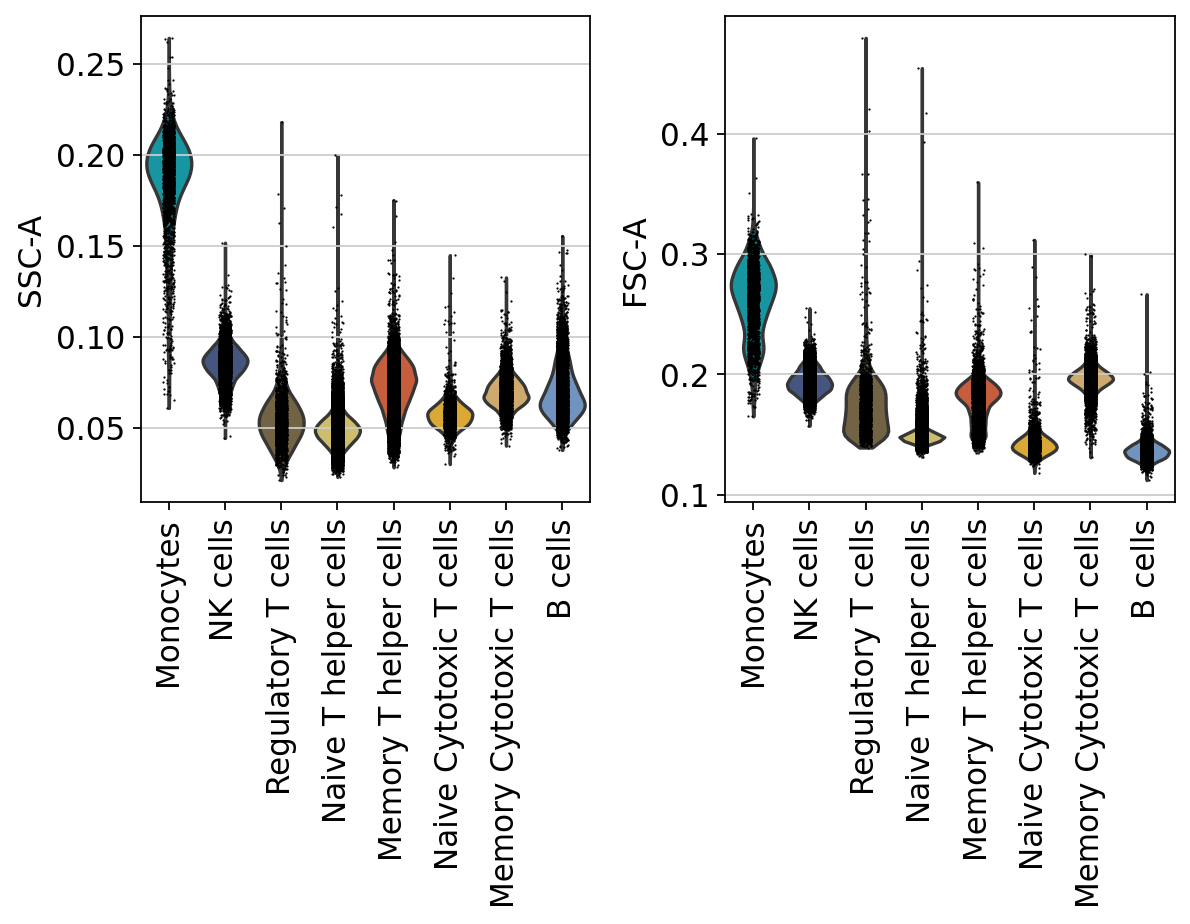

In [75]:
# plot scatter in violins
order = ['Monocytes', 'NK cells', 'Regulatory T cells', 'Naive T helper cells', 'Memory T helper cells', 'Naive Cytotoxic T cells', 'Memory Cytotoxic T cells', 'B cells']
sc.pl.violin(adata_cytof, keys = ['SSC-A', 'FSC-A'], groupby='harmonized_labels', layer='imputed', rotation = 90, order = order, palette = cell_type_colors, save = 'violin_plot_scatter_imputation_CyTOF_scatter.pdf')
sc.pl.violin(adata_cytof, keys = ['SSC-A', 'FSC-A'], groupby='harmonized_labels', layer='imputed', rotation = 90, order = order, palette = cell_type_colors, save = 'violin_plot_scatter_imputation_CyTOF_scatter.png')

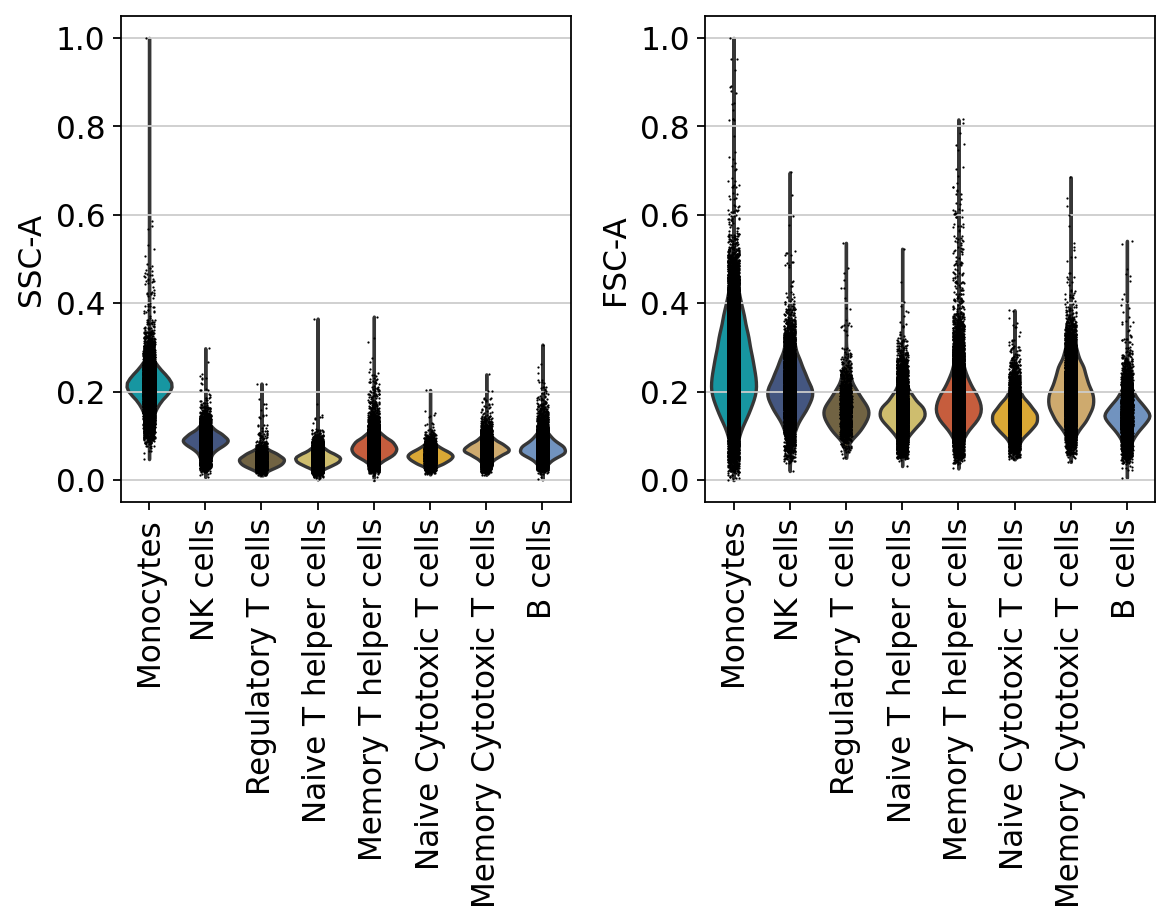

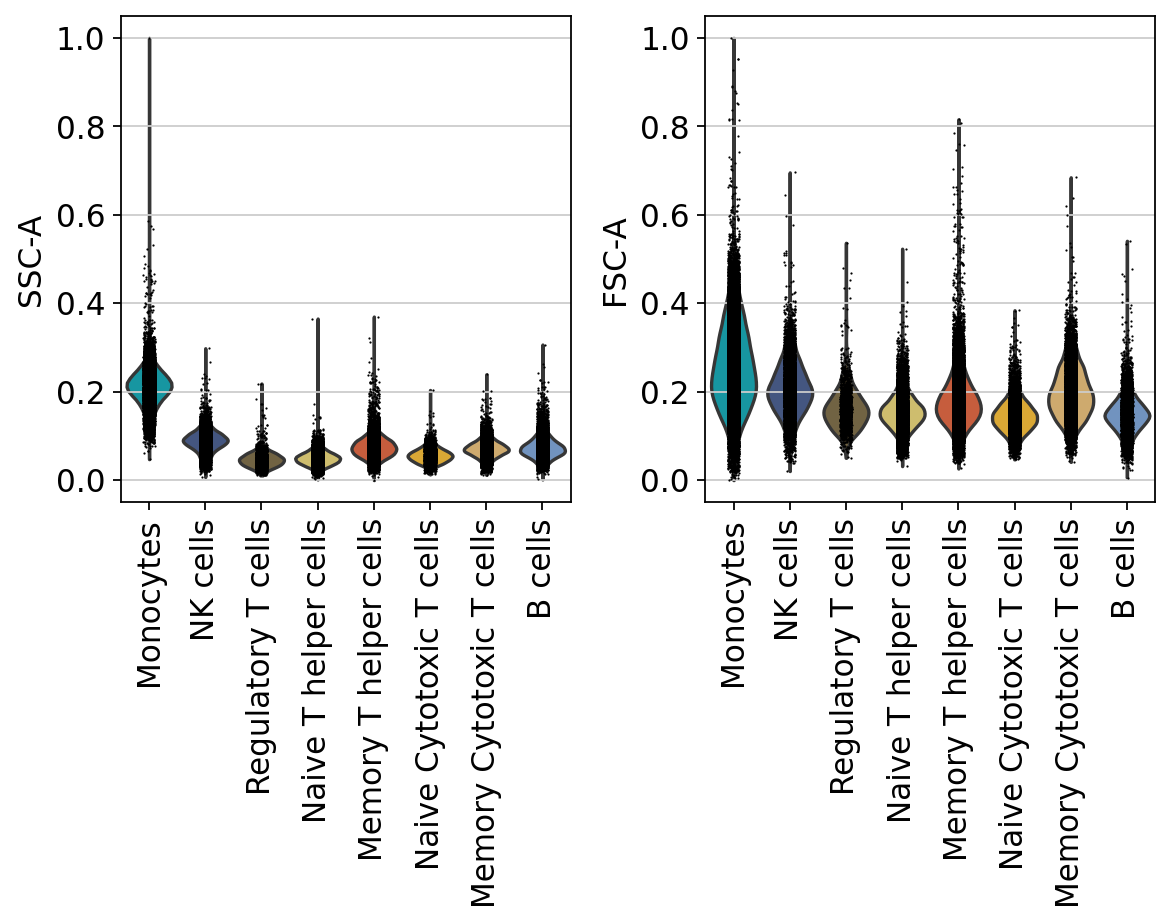

In [76]:
# plot GT scatter
adata_flow = adata[adata.obs['batch']=='0'].copy()
sc.pl.violin(adata_flow, keys = ['SSC-A', 'FSC-A'], groupby='harmonized_labels', layer='scaled', rotation = 90, palette = cell_type_colors, order = order, save = 'violin_plot_scatter_imputation_GT_flow_scatter.pdf')
sc.pl.violin(adata_flow, keys = ['SSC-A', 'FSC-A'], groupby='harmonized_labels', layer='scaled', rotation = 90, palette = cell_type_colors, order = order, save = 'violin_plot_scatter_imputation_GT_flow_scatter.png')

In [9]:
# plot ground truth data
flow_kwargs {
    'layer_key': 'scaled',
    'color': 'harmonized_labels',
    'n_obs': 50000,
    'height': 4,
    'palette': cell_type_colors,
    'sample_color_groups': True,
    'scatter_kwargs': {'edgecolor': 'none'},
}
adata_flow = adata_flow[adata_flow.obs['harmonized_labels'].isin(order)]
cytovi.pl.biaxial(adata_flow, marker_y = 'CD14', marker_x = ['FSC-A', 'SSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_GT_flow_CD14_scatter.png', **flow_kwargs)
cytovi.pl.biaxial(adata_flow, marker_y = 'CD14', marker_x = ['FSC-A', 'SSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_GT_flow_CD14_scatter.pdf', **flow_kwargs)
cytovi.pl.biaxial(adata_flow, marker_y = 'SSC-A', marker_x = ['FSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_GT_flow_scatter.png', **flow_kwargs)
cytovi.pl.biaxial(adata_flow, marker_y = 'SSC-A', marker_x = ['FSC-A'], save=f'{figure_dir}biaxial_plot_scatter_imputation_GT_flow_scatter.pdf', **flow_kwargs)

SyntaxError: invalid syntax (1012199162.py, line 2)

In [48]:
# compare group statistics 
data_df_cytof = pd.DataFrame(adata_cytof[:, ['FSC-A', 'SSC-A']].layers['imputed'], columns=adata_cytof[:, ['FSC-A', 'SSC-A']].var_names)
data_df_cytof['harmonized_labels'] = adata_cytof.obs['harmonized_labels'].values
imputed_label_means = data_df_cytof.groupby('harmonized_labels').mean()

data_df_flow = pd.DataFrame(adata_flow[:, ['FSC-A', 'SSC-A']].layers['imputed'], columns=adata_flow[:, ['FSC-A', 'SSC-A']].var_names)
data_df_flow['harmonized_labels'] = adata_flow.obs['harmonized_labels'].values
gt_label_means = data_df_flow.groupby('harmonized_labels').mean()

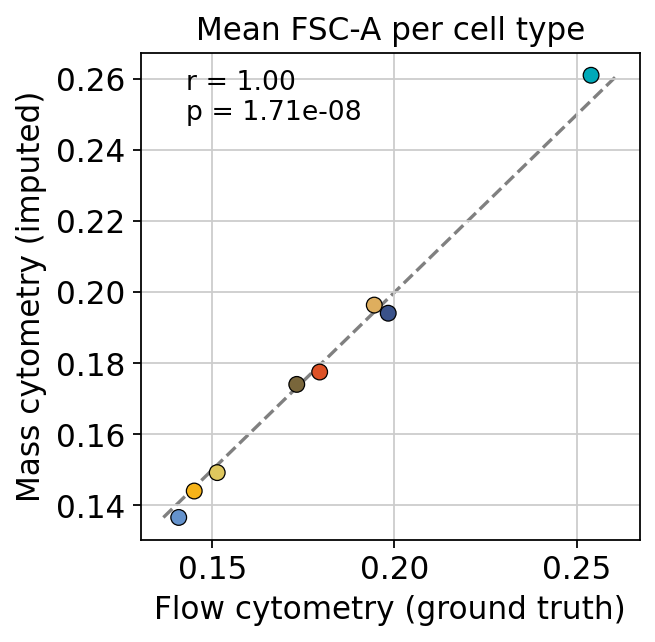

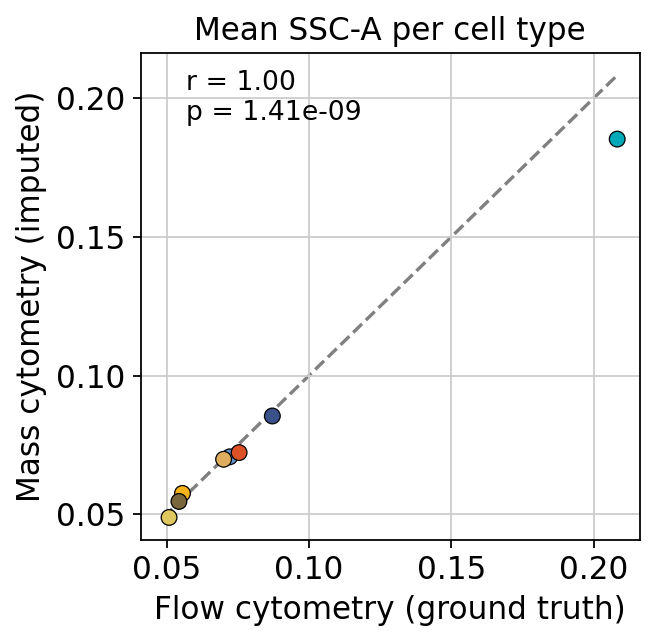

In [73]:
# plot FSC means
from scipy.stats import pearsonr

features = ['FSC-A', 'SSC-A']

for feature in features:
    g = sns.scatterplot(x = gt_label_means[feature], y = imputed_label_means[feature], hue =  gt_label_means.index, palette = cell_type_colors, s = 50, edgecolor = 'black', zorder = 2)
    plt.xlabel('Flow cytometry (ground truth)')
    plt.ylabel('Mass cytometry (imputed)')
    plt.title(f'Mean {feature} per cell type')

    # Add a diagonal line
    min_val = min(gt_label_means[feature].min(), imputed_label_means[feature].min())
    max_val = max(gt_label_means[feature].max(), imputed_label_means[feature].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', zorder = 1)


    r, p = pearsonr(gt_label_means[feature],imputed_label_means[feature])

    # Display Pearson r and p-value on the plot
    plt.text(min_val + (max_val - min_val) * 0.05, max_val - (max_val - min_val) * 0.1,
            f'r = {r:.2f}\np = {p:.2e}', 
            fontsize=12, color='black')

    plt.legend([], [], frameon=False)
    plt.savefig(f'{figure_dir}scatterplot_{feature}_imputed_vs_GT.pdf')
    plt.show()


In [74]:
# save anndata
adata.write_h5ad('../data/2024-06-14_imputation_eval_batch/2024-08-27_kreutmair_nunez_annotated_imputed.h5ad')